In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import optuna


import tensorflow as tf
tf.random.set_seed(999)
from tensorflow.keras.regularizers import L1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,BatchNormalization,Activation
from tensorflow.keras import regularizers



panel = pd.read_pickle('../Data/returns_chars_panel.pkl') 
macro = pd.read_pickle('../Data/macro_timeseries.pkl')

In [64]:
# combine micro and macro data
df = pd.merge(panel,macro,on='date',how='left',suffixes=['','_macro']) 

# features + targets 
X = df.drop(columns=['ret','excess_ret','rfree','permno','date']) # everything except return info and IDs
y = df['excess_ret'] 

# Split Train Test 

In [65]:
# make 20 years of training data
date = df['date']
training = (date <= '1977-03') # selects 
X_train, y_train = X.loc[training].values, y.loc[training].values 

# make 10 years of validation data
validation = (date > '1977-03') & (date <= '1987-03') 
X_val, y_val = X.loc[validation].values, y.loc[validation].values 

# make test data
test = (date > '1987-03') 
X_test, y_test = X.loc[test].values, y.loc[test].values 

In [86]:
# lamda = 1e-5
epochs = 100
# learning_rate = 0.0001
patience = 5
batch_size = 10000

# Finding baseline model for Neural Network 

In [87]:
# create the final model 
def create_nn(n_layers, input_dim, lamda, learning_rate):
    first_layer = 32
    num_layers = 32 
    optimizer = Adam(learning_rate=learning_rate)
    model = Sequential()
    model.add(Dense(32, input_dim=input_dim, 
                kernel_regularizer=regularizers.L1(lamda), 
                kernel_initializer = 'he_normal'))
    model.add(BatchNormalization())

    # add extra hidden layers 
    for i in range(n_layers - 1): 
        num_layers = int(num_layers / 2)
        print(num_layers)
        model.add(Dense(num_layers,
                kernel_regularizer=regularizers.L1(lamda), 
                kernel_initializer = 'he_normal'))
        model.add(BatchNormalization())
        
    # output layer 
    model.add(Dense(1, activation='linear',
                    kernel_regularizer=regularizers.L1(0.01), 
                    kernel_initializer = 'he_normal'))

    model.compile(loss='mse', 
                optimizer=optimizer,
                metrics = ['mse']) 
    return model 


## Cross Validation for Lamda for L2 Regularization 

In [90]:
# Using Optuna to cross validate hyper parameter 
input_dim = X_train.shape[1]
n_layers = 2
def create_model(trial):

    num_layers = 32 
    # Suggest hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.01, log=True)
    l1_reg = trial.suggest_float('l1_reg', 1e-5, 1e-3, log=True)

    optimizer = Adam(learning_rate=learning_rate)
    model = Sequential()
    model.add(Dense(32, input_dim=input_dim, 
                kernel_regularizer=regularizers.L1(l1_reg), 
                kernel_initializer = 'he_normal'))
    model.add(BatchNormalization())

    # add extra hidden layers 
    for i in range(n_layers - 1): 
        num_layers = int(num_layers / 2)
        print(num_layers)
        model.add(Dense(num_layers,
                kernel_regularizer=regularizers.L1(l1_reg), 
                kernel_initializer = 'he_normal'))
        model.add(BatchNormalization())
        
    # output layer 
    model.add(Dense(1, activation='linear',
                    kernel_regularizer=regularizers.L1(0.01), 
                    kernel_initializer = 'he_normal'))

    model.compile(loss='mse', 
                optimizer=optimizer,
                metrics = ['mse']) 
    return model

# Objective function for Optuna
def objective(trial):
    model = create_model(trial)
    
    # Use early stopping
    early_stopping = EarlyStopping(patience=patience, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs,
        batch_size,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluate the model
    score = model.evaluate(X_val, y_val, verbose=0)
    return score[0]

# Create a study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Get the best trial
best_trial = study.best_trial

print("Best trial:")
print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")



[I 2024-05-24 09:51:22,255] A new study created in memory with name: no-name-3f083e90-4b67-457e-8315-1fe24896cbbe


16


[I 2024-05-24 09:51:53,688] Trial 0 finished with value: 0.02663322351872921 and parameters: {'learning_rate': 0.005884424119274088, 'l1_reg': 1.5027262158789137e-05}. Best is trial 0 with value: 0.02663322351872921.


16


[I 2024-05-24 09:52:35,638] Trial 1 finished with value: 0.026709742844104767 and parameters: {'learning_rate': 0.0017210962358792364, 'l1_reg': 9.376859223285416e-05}. Best is trial 0 with value: 0.02663322351872921.


16


[I 2024-05-24 09:53:01,404] Trial 2 finished with value: 0.02648334763944149 and parameters: {'learning_rate': 0.0014705134062547398, 'l1_reg': 1.649558851353367e-05}. Best is trial 2 with value: 0.02648334763944149.


16


[I 2024-05-24 09:54:06,528] Trial 3 finished with value: 0.0268534068018198 and parameters: {'learning_rate': 0.009877711158990365, 'l1_reg': 2.2540953606748685e-05}. Best is trial 2 with value: 0.02648334763944149.


16


[I 2024-05-24 09:54:29,955] Trial 4 finished with value: 0.026836102828383446 and parameters: {'learning_rate': 0.004063465287472252, 'l1_reg': 0.00017841762918646364}. Best is trial 2 with value: 0.02648334763944149.


16


[I 2024-05-24 09:54:50,887] Trial 5 finished with value: 0.026734134182333946 and parameters: {'learning_rate': 0.0033445223041875948, 'l1_reg': 0.0001735058350691107}. Best is trial 2 with value: 0.02648334763944149.


16


[I 2024-05-24 09:55:10,398] Trial 6 finished with value: 0.027333185076713562 and parameters: {'learning_rate': 0.006004271376997853, 'l1_reg': 0.00037495134301516114}. Best is trial 2 with value: 0.02648334763944149.


16


[I 2024-05-24 09:55:29,276] Trial 7 finished with value: 0.026592226698994637 and parameters: {'learning_rate': 0.00295393519069072, 'l1_reg': 0.000152413821510078}. Best is trial 2 with value: 0.02648334763944149.


16


[I 2024-05-24 09:56:09,281] Trial 8 finished with value: 0.026458438485860825 and parameters: {'learning_rate': 0.0020114891212278073, 'l1_reg': 1.965055174486702e-05}. Best is trial 8 with value: 0.026458438485860825.


16


[I 2024-05-24 09:56:30,779] Trial 9 finished with value: 0.026772230863571167 and parameters: {'learning_rate': 0.00575191729726104, 'l1_reg': 0.00015495480138570146}. Best is trial 8 with value: 0.026458438485860825.


16


[I 2024-05-24 09:56:55,600] Trial 10 finished with value: 0.026645846664905548 and parameters: {'learning_rate': 0.0021279007665057875, 'l1_reg': 4.3440896219815514e-05}. Best is trial 8 with value: 0.026458438485860825.


16


[W 2024-05-24 09:57:10,985] Trial 11 failed with parameters: {'learning_rate': 0.0010030927962998086, 'l1_reg': 1.1113557467250788e-05} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/dhammatornriewcharoon/anaconda3/lib/python3.11/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/df/x7ngsr_15bx8pln6jsqgdxy00000gn/T/ipykernel_2523/3233190141.py", line 43, in objective
    history = model.fit(
              ^^^^^^^^^^
  File "/Users/dhammatornriewcharoon/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/Users/dhammatornriewcharoon/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 314, in fit
    logs = self.train_function(iterator)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 

KeyboardInterrupt: 

/Users/dhammatornriewcharoon/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16
8
4
Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.3309 - mse: 1.3050 - val_loss: 1.2189 - val_mse: 1.1931
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7095 - mse: 0.6837 - val_loss: 0.5933 - val_mse: 0.5676
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3662 - mse: 0.3404 - val_loss: 0.3846 - val_mse: 0.3589
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2110 - mse: 0.1853 - val_loss: 0.2652 - val_mse: 0.2395
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1391 - mse: 0.1134 - val_loss: 0.1887 - val_mse: 0.1630
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1024 - mse: 0.0767 - val_loss: 0.1414 - val_mse: 0.1157
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0817 - mse: 0.0560 - val_loss: 0.1125 - val_mse: 0.0868
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0694 - mse: 0.0437 - val_loss: 0.0946 - val_mse: 0.0689
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - l

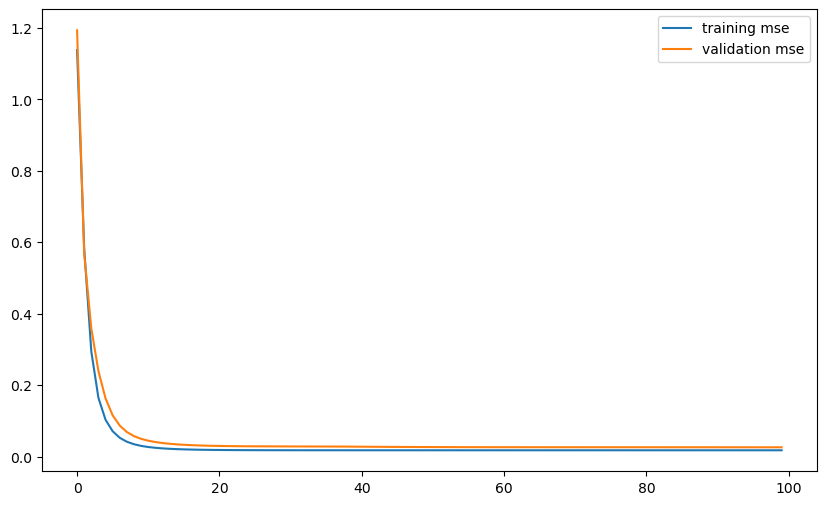

In [84]:
optimizer = Adam(learning_rate=learning_rate)
model = create_nn(4 , X_train.shape[1], lamda, learning_rate)
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=True,
                    validation_data=(X_val, y_val),
                    callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)])

# Plotting the training and validation MSE
fig, ax = plt.subplots(figsize=(10, 6))
pd.Series(history.history['mse']).plot(ax=ax, label='training mse')
pd.Series(history.history['val_mse']).plot(ax=ax, label='validation mse')
ax.legend()
plt.show()

    


In [ ]:
total_R_2_OOS = [] 
for i in range(1977, 1987):
    train_window = (date < datetime(i+1,1,1)) 
    test_window = (date >= datetime(i,1,1)) & (date < datetime(i+1,1,1)) 
    # print('Train', np.sum(train_window))
    # print('Test', np.sum(test_window))
    X_train_expanding, y_train_expanding = X.loc[train_window].values, y.loc[train_window].values
    X_test_expanding, y_test_expanding =  X.loc[test_window].values, y.loc[test_window].values

    lamda = 1e-5
    epochs = 100
    learning_rate = 0.0001
    patience = 5
    batch_size = 10000

    optimizer = Adam(learning_rate=learning_rate)
    model = nn3(lamda)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
    history = model.fit(X_train_expanding, y_train_expanding, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        verbose=True,
                        validation_data=(X_val, y_val),
                        callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)])

    # Plotting the training and validation MSE
    fig, ax = plt.subplots(figsize=(10, 6))
    pd.Series(history.history['mse']).plot(ax=ax, label='training mse')
    pd.Series(history.history['val_mse']).plot(ax=ax, label='validation mse')
    ax.legend()
    plt.show()

    predictions = model.predict(X_val)
    print(predictions)
    df_predictions = pd.DataFrame(predictions, columns=['Prediction'])
    df_predictions['Actual'] = y_val
    df_predictions['dif_squared'] = (df_predictions['Prediction'] - df_predictions['Actual'])**2
    df_predictions['actual_sqaured'] = df_predictions['Actual']**2
    R_OOS = 1 - (df_predictions['dif_squared'].sum()/df_predictions['actual_sqaured'].sum()) 
    R_OOS
    

## Rolling Window R^2_OOS 

In [60]:
end_year = date.max()

total_R_2_OOS = [] 
model = nn2(lamda)
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

for i in range(1987 + 1, end_year.year):
    print(i)
    train_window = (date > datetime(1987,3,1)) & (date < datetime(i+1,1,1)) 
    test_window = (date >= datetime(i,1,1)) & (date < datetime(i+1,1,1)) 
    # print('Train', np.sum(train_window))
    # print('Test', np.sum(test_window))
    X_train_expanding, y_train_expanding = X.loc[train_window].values, y.loc[train_window].values
    X_test_expanding, y_test_expanding =  X.loc[test_window].values, y.loc[test_window].values

    # model.summary()
    history = model.fit(X_train_expanding, y_train_expanding, 
                        epochs=100, 
                        batch_size=batch_size, 
                        verbose=True,
                        validation_data = (X_val, y_val),
                        #TODO 
                        # Defined the callback to see if the validation result actually improves 
                        callbacks = [EarlyStopping(patience = patience, restore_best_weights=True)])
    predictions = model.predict(X_test_expanding)
    df_predictions = pd.DataFrame(predictions, columns=['Prediction'])
    df_predictions['Actual'] = y_test_expanding
    df_predictions['dif_squared'] = (df_predictions['Prediction'] - df_predictions['Actual'])**2
    df_predictions['actual_sqaured'] = df_predictions['Actual']**2
    R_OOS = 1 - (df_predictions['dif_squared'].sum()/df_predictions['actual_sqaured'].sum()) 
    total_R_2_OOS.append(R_OOS)


    
    
    


1988
Epoch 1/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.5509 - mse: 0.5499 - val_loss: 0.0569 - val_mse: 0.0559
Epoch 2/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0477 - mse: 0.0467 - val_loss: 0.0396 - val_mse: 0.0386
Epoch 3/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0357 - mse: 0.0347 - val_loss: 0.0344 - val_mse: 0.0334
Epoch 4/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0326 - mse: 0.0316 - val_loss: 0.0318 - val_mse: 0.0309
Epoch 5/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0313 - mse: 0.0303 - val_loss: 0.0305 - val_mse: 0.0296
Epoch 6/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0306 - mse: 0.0297 - val_loss: 0.0297 - val_mse: 0.0288
Epoch 7/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0302 - mse: 0.0293 - val_loss: 0.0293 - val_mse: 0.0284
Epoch 8/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0299 - mse: 0.0290 - val_loss: 0.0291 - val_mse: 0.0282
Epoch 9/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s

In [61]:
np.mean(total_R_2_OOS)

0.012938800713457991